In [1]:
import os, cv2, time
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import albumentations as album

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

from torchvision import transforms

from PIL import Image

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

In [2]:
#with torch.no_grad():
#    torch.cuda.empty_cache()

In [3]:
def create_paths(dataset_dir):
    rgb_files = []
    mask_files = []
    for root, dirs, files in os.walk(dataset_dir):
        for name in files:
            f = os.path.join(root, name)
            if 'labelIds' in f:
                mask_files.append(f)
            elif 'rgb_anon' in f:
                rgb_files.append(f)
            else:
                pass
    return sorted(rgb_files), sorted(mask_files)

In [4]:
class customDataset(Dataset):
    """ Custom Dataset for multiclass semantic segmentation.

    Args:
        df (pd.DataFrame): DataFrame containing paths to images and masks.
        class_list (list): List of class IDs to extract from segmentation mask.
        preprocessing (callable, optional): Data preprocessing function.
    """
    
    def __init__(self, df, class_list=None, augmentation=None, preprocessing=None):
        self.image_paths = df['rgb_file'].tolist()
        self.mask_paths = df['mask_file'].tolist()

        self.class_list = class_list
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        # Original Cityscapes IDs to be mapped to your 6 classes
        # [7, 11, 21, 26, 23, 24] # ['road', 'building', 'vegetation', 'car', 'sky', 'person']
        self.cityscapes_ids = [7, 11, 21, 26, 23]  # Target classes
        # Mapping to new class indices [0, 1, 2, 3, 4, 5]
        self.new_class_mapping = {7: 1, 11: 2, 21: 3, 26: 4, 23: 5}   
        # Define a background class ID
        #self.background_class_id = -1  # Or any other value not used by your classes

    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2GRAY)  # Read mask as grayscale

        # Resize images and masks (640, 480)/(1920, 1080)
        image = cv2.resize(image, (1920, 1056), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (1920, 1056), interpolation=cv2.INTER_NEAREST)

        image = np.asarray(image).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            image = self.preprocessing(image)
            image = torch.as_tensor(image)
        else:
            # Normalize image to [0, 1]
            image = torch.as_tensor(image) / 255.0
        image = image.permute(2,0,1)

        # Convert mask to tensor
        #mask = torch.as_tensor(mask, dtype=torch.uint8)
        
        # Map original Cityscapes IDs to the new class indices
        mask_mapped = np.zeros_like(mask, dtype=np.uint8)  # Initialize new mask
        for original_id, new_id in self.new_class_mapping.items():
            mask_mapped[mask == original_id] = new_id

        # Convert mask to tensor with the mapped classes
        mask_tensor = torch.as_tensor(mask_mapped, dtype=torch.long)

        # -------------------
        # Convert mask to tensor and remap class IDs
        #mask = torch.as_tensor(mask, dtype=torch.uint8)
        #mask_mapped = torch.full_like(mask, self.background_class_id, dtype=torch.long)  # Initialize new mask with background class ID
        
        #for original_id, new_id in self.new_class_mapping.items():
        #    mask_mapped[mask == original_id] = new_id

        return image.float(), mask_tensor

    def __len__(self):
        return len(self.image_paths)


In [5]:
# for Carla-Night dataset
dataset_carla_dir = '/home/vhsillerico/Documents/datasets/carla-night'
imgs_rgb, imgs_mask = create_paths(dataset_carla_dir)
df_carla = pd.DataFrame({'rgb_file': imgs_rgb, 'mask_file': imgs_mask})
df_carla.sort_values(by='rgb_file',inplace=True)
df_carla.reset_index(drop=True, inplace=True)
df_carla = df_carla.sample(frac=1).reset_index(drop=True)
df_carla.head(5)

# Split data 85% for trainig and 15% for validation
df_carla_train, df_carla_val = train_test_split(df_carla, test_size=0.20)

df_carla_train.reset_index(drop=True, inplace=True)
df_carla_val.reset_index(drop=True, inplace=True)

print(f'carla-shape = {df_carla.shape} --- train-shape={df_carla_train.shape} --- val-shape={df_carla_val.shape}')

carla-shape = (1000, 2) --- train-shape=(800, 2) --- val-shape=(200, 2)


In [6]:
# for ACDC-Night dataset
dataset_acdc_dir = '/home/vhsillerico/Documents/datasets/acdc-night'
imgs_acdc_rgb, imgs_acdc_mask = create_paths(dataset_acdc_dir)
#print(f'LEN imgs_acdc_rgb: {len(imgs_acdc_rgb)} --- LEN imgs_acdc_mask: {len(imgs_acdc_mask)}')
df_acdc = pd.DataFrame({'rgb_file': imgs_acdc_rgb, 'mask_file': imgs_acdc_mask})
df_acdc.sort_values(by='rgb_file',inplace=True)
df_acdc.reset_index(drop=True, inplace=True)
df_acdc = df_acdc.sample(frac=1).reset_index(drop=True)
df_acdc.head(5)

# Split data 85% for trainig and 15% for validation
df_acdc_train, df_acdc_val = train_test_split(df_acdc, test_size=0.15)

df_acdc_train.reset_index(drop=True, inplace=True)
df_acdc_val.reset_index(drop=True, inplace=True)

print(f'acdc-shape = {df_acdc.shape} --- train-shape={df_acdc_train.shape} --- val-shape={df_acdc_val.shape}')

acdc-shape = (506, 2) --- train-shape=(430, 2) --- val-shape=(76, 2)


In [7]:
# Concatenate the datasets (ACDC + CARLA)
# Training set
df_merged_train = pd.concat([df_carla_train, df_acdc_train], ignore_index=True)
df_merged_train = df_merged_train.sample(frac=1).reset_index(drop=True)
#df_merged_train.head(20)
print(f'merged-train-shape = {df_merged_train.shape}')

merged-train-shape = (1230, 2)


In [8]:
# Validation set
df_merged_val = pd.concat([df_carla_val, df_acdc_val], ignore_index=True)
df_merged_val = df_merged_val.sample(frac=1).reset_index(drop=True)
#df_merged_val.head(20)
print(f'merged-val-shape = {df_merged_val.shape}')

merged-val-shape = (276, 2)


In [9]:
selected_class_list = [7, 11, 21, 26, 23] # ['road', 'building', 'vegetation', 'car', 'sky', 'person']

In [10]:
#activation = torch.nn.Softmax(dim=1)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

BACKBONE = 'resnet34'
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

In [11]:
# image dimensions: (480, 640) (H,W)
global h_aux, w_aux
h_aux = 1056
w_aux = 1920
h_crop_size = 1056
w_crop_size = 1920
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=h_crop_size, width=w_crop_size, always_apply=True),
        album.PadIfNeeded(min_height=h_aux, min_width=w_aux, always_apply=True, border_mode=0, value=(0, 0, 0)),
        album.HorizontalFlip(p=0.75),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        #album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0, value=(0, 0, 0)),
        album.PadIfNeeded(min_height=h_aux, min_width=w_aux, always_apply=True, border_mode=0, value=(0, 0, 0)),
    ]
    return album.Compose(test_transform)

In [12]:
# configure dataset for training
train_data = customDataset(df_merged_train, class_list=selected_class_list, preprocessing=preprocess_input)
img_train, masks_train = train_data[1]
print(img_train.shape, masks_train.shape)

torch.Size([3, 1056, 1920]) torch.Size([1056, 1920])


In [13]:
np.unique(masks_train.detach().cpu().numpy())

array([0, 1, 2, 3, 4, 5])

In [14]:
#def visualize(**images):
#    """
#    Plot images in one row
#    """
#    n_images = len(images)
#    plt.figure(figsize=(20,8))
#    for idx, (name, image) in enumerate(images.items()):
#        plt.subplot(1, n_images, idx + 1)
#        plt.xticks([]);
#        plt.yticks([])
#        # get title from the parameter names
#        plt.title(name.replace('_',' ').title(), fontsize=20)
#        plt.imshow(image)
#    plt.show()

In [15]:
# configure dataset for training
val_data = customDataset(df_merged_val, class_list=selected_class_list, preprocessing=preprocess_input)
img_val, masks_val = val_data[0]
print(img_val.shape, masks_val.shape)

torch.Size([3, 1056, 1920]) torch.Size([1056, 1920])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


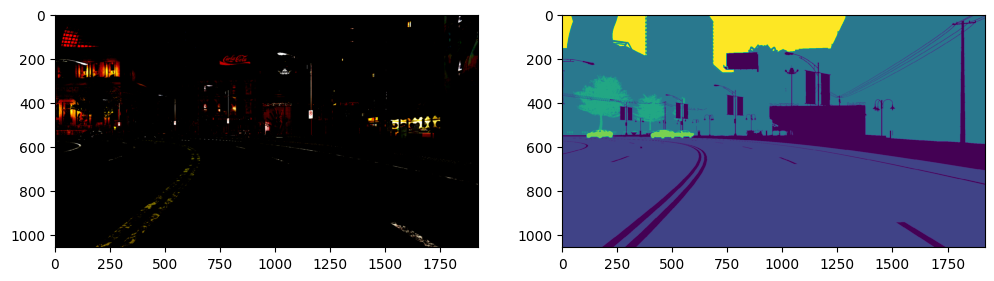

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(img_train.permute(1, 2, 0))
ax[1].imshow(masks_train) # ['road', 'building', 'vegetation', 'car', 'sky', 'person']
plt.show()

In [17]:
train_data_loader = DataLoader(
    train_data,
    batch_size=4,
    shuffle=True
)
val_data_loader = DataLoader(
    val_data,
    batch_size=2,
    shuffle=False
)

In [18]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    break

torch.Size([4, 3, 1056, 1920]) torch.Size([4, 1056, 1920])
tensor(-2.1179) tensor(2.6400)
tensor(0) tensor(5)


In [19]:
# COMPLETE FINAL VERSION ************************************

# Function to compute IoU per class
def compute_iou(pred, target, num_classes):
    iou_list = []
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        
        intersection = torch.sum(pred_cls * target_cls)
        union = torch.sum(pred_cls) + torch.sum(target_cls) - intersection
        
        iou = intersection / (union + 1e-7)  # Adding epsilon to avoid division by zero
        iou_list.append(iou.item())
    
    return iou_list

# Function to compute F1-score per class
def compute_f1_score(pred, target, num_classes):
    f1_scores = []
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        
        intersection = torch.sum(pred_cls * target_cls)
        precision = intersection / (torch.sum(pred_cls) + 1e-7)
        recall = intersection / (torch.sum(target_cls) + 1e-7)
        
        f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
        f1_scores.append(f1.item())
    
    return f1_scores

# Initialize DataFrame to store logs
logs_df = pd.DataFrame(columns=[
    'Epoch', 'Train_Loss', 'Train_IoU_per_Class', 'Train_Mean_IoU',
    'Train_F1_per_Class', 'Train_Mean_F1',
    'Val_Loss', 'Val_IoU_per_Class', 'Val_Mean_IoU',
    'Val_F1_per_Class', 'Val_Mean_F1'
])

num_classes = 6
num_epochs = 30  # Adjust as needed


# Define your model, loss function, and optimizer
segmodel = smp.FPN(encoder_name='resnet34', encoder_weights='imagenet', classes=num_classes, activation=None).to(device)
# Define your model with dropout
#segmodel = smp.Unet(BACKBONE, classes=num_classes, activation=None, encoder_weights=None, dropout=dropout_rate).to(device)

criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(segmodel.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = torch.optim.Adam(segmodel.parameters(), lr=0.001)

# Initialize DataFrame to store logs
logs_df = pd.DataFrame(columns=['Epoch',
                                'Train_Loss',
                                'Train_IoU_per_Class',
                                'Train_Mean_IoU',
                                'Train_F1_per_Class',
                                'Train_Mean_F1',
                                'Val_Loss',
                                'Val_IoU_per_Class',
                                'Val_Mean_IoU',
                                'Val_F1_per_Class',
                                'Val_Mean_F1'])
# Train model
max_score = 0

# Training and validation loop
for epoch in range(num_epochs):
    start_time = time.time()  # Track start time
    # Training
    segmodel.train()
    train_loss = 0
    train_iou_scores = []
    train_f1_scores = []
    
    # Progress bar for training
    with tqdm(total=len(train_data_loader), desc=f'Epoch {epoch + 1}/{num_epochs} - Training', unit='batch') as pbar:
        for batch in train_data_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            pred = segmodel(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Calculate IoU and F1-score
            pred_classes = torch.argmax(pred, dim=1)
            iou = compute_iou(pred_classes, y, num_classes)
            f1_score = compute_f1_score(pred_classes, y, num_classes)
            
            train_iou_scores.append(iou)
            train_f1_scores.append(f1_score)
            
            pbar.set_postfix({'Train_Loss': loss.item(), 'IoU': np.mean(iou), 'F1': np.mean(f1_score)})
            pbar.update(1)
    
    # Calculate mean metrics for training
    avg_train_iou = np.mean(train_iou_scores, axis=0)
    mean_train_iou = np.mean(avg_train_iou)
    avg_train_f1 = np.mean(train_f1_scores, axis=0)
    mean_train_f1 = np.mean(avg_train_f1)
    avg_train_loss = train_loss / len(train_data_loader)
    
    # Validation
    segmodel.eval()
    val_loss = 0
    val_iou_scores = []
    val_f1_scores = []
    
    with torch.no_grad():
        # Progress bar for validation
        with tqdm(total=len(val_data_loader), desc=f'Epoch {epoch + 1}/{num_epochs} - Validation', unit='batch') as pbar:
            for batch in val_data_loader:
                x, y = batch
                x, y = x.to(device), y.to(device)
                pred = segmodel(x)
                
                loss = criterion(pred, y)
                val_loss += loss.item()
                
                # Calculate IoU and F1-score
                pred_classes = torch.argmax(pred, dim=1)
                iou = compute_iou(pred_classes, y, num_classes)
                f1_score = compute_f1_score(pred_classes, y, num_classes)
                
                val_iou_scores.append(iou)
                val_f1_scores.append(f1_score)
                
                pbar.set_postfix({'Val_Loss': loss.item(), 'IoU': np.mean(iou), 'F1': np.mean(f1_score)})
                pbar.update(1)
    
    # Calculate mean metrics for validation
    avg_val_iou = np.mean(val_iou_scores, axis=0)
    mean_val_iou = np.mean(avg_val_iou)
    avg_val_f1 = np.mean(val_f1_scores, axis=0)
    mean_val_f1 = np.mean(avg_val_f1)
    avg_val_loss = val_loss / len(val_data_loader)
    
    # Save logs to DataFrame
    new_log = {
        'Epoch': epoch + 1,
        'Train_Loss': avg_train_loss,
        'Train_IoU_per_Class': avg_train_iou,
        'Train_Mean_IoU': mean_train_iou,
        'Train_F1_per_Class': avg_train_f1,
        'Train_Mean_F1': mean_train_f1,
        'Val_Loss': avg_val_loss,
        'Val_IoU_per_Class': avg_val_iou,
        'Val_Mean_IoU': mean_val_iou,
        'Val_F1_per_Class': avg_val_f1,
        'Val_Mean_F1': mean_val_f1
    }
    # Convert the new_row dictionary to a DataFrame
    new_log_df = pd.DataFrame([new_log])
    # Concatenate the new_row_df to logs_df
    logs_df = pd.concat([logs_df, new_log_df], ignore_index=True)
    
    # Print metrics
    print(f"Epoch {epoch + 1}/{num_epochs} - "
          f"Mean Train IoU: {mean_train_iou:.4f}, "
          f"Mean Train F1-score: {mean_train_f1:.4f}, "
          f"Avg Train Loss: {avg_train_loss:.4f}, "
          f"Mean Val IoU: {mean_val_iou:.4f}, "
          f"Mean Val F1-score: {mean_val_f1:.4f}, "
          f"Avg Val Loss: {avg_val_loss:.4f}")

    # Calculate and print time for each epoch
    epoch_time = time.time() - start_time
    print(f"Time: {epoch_time:.2f} seconds")

    # Save the model if it's the best one
    if mean_val_iou > max_score:
        max_score = mean_val_iou
        torch.save(segmodel.state_dict(), './best_model_FPN_multiclass_merged30e.pth')
        print('Model saved!')

total_time = epoch_time * num_epochs
print(f"Estimated total training time: {total_time/60:.2f} minutes")
# Save DataFrame to CSV
logs_df.to_csv('best_model_FPN_multiclass_merged30e.csv', index=False)


Epoch 1/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 1/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 1/30 - Mean Train IoU: 0.5138, Mean Train F1-score: 0.6348, Avg Train Loss: 0.7223, Mean Val IoU: 0.6098, Mean Val F1-score: 0.7264, Avg Val Loss: 0.5044
Time: 309.83 seconds
Model saved!


Epoch 2/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 2/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 2/30 - Mean Train IoU: 0.6386, Mean Train F1-score: 0.7570, Avg Train Loss: 0.4516, Mean Val IoU: 0.6732, Mean Val F1-score: 0.7779, Avg Val Loss: 0.3654
Time: 296.30 seconds
Model saved!


Epoch 3/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 3/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 3/30 - Mean Train IoU: 0.6876, Mean Train F1-score: 0.7976, Avg Train Loss: 0.3800, Mean Val IoU: 0.6338, Mean Val F1-score: 0.7388, Avg Val Loss: 0.3718
Time: 300.42 seconds


Epoch 4/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 4/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 4/30 - Mean Train IoU: 0.7031, Mean Train F1-score: 0.8094, Avg Train Loss: 0.3474, Mean Val IoU: 0.6947, Mean Val F1-score: 0.7923, Avg Val Loss: 0.3162
Time: 308.41 seconds
Model saved!


Epoch 5/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 5/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 5/30 - Mean Train IoU: 0.7222, Mean Train F1-score: 0.8246, Avg Train Loss: 0.3247, Mean Val IoU: 0.6383, Mean Val F1-score: 0.7393, Avg Val Loss: 0.3973
Time: 302.12 seconds


Epoch 6/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 6/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 6/30 - Mean Train IoU: 0.7338, Mean Train F1-score: 0.8330, Avg Train Loss: 0.3097, Mean Val IoU: 0.7283, Mean Val F1-score: 0.8215, Avg Val Loss: 0.2821
Time: 305.38 seconds
Model saved!


Epoch 7/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 7/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 7/30 - Mean Train IoU: 0.7493, Mean Train F1-score: 0.8447, Avg Train Loss: 0.2858, Mean Val IoU: 0.6921, Mean Val F1-score: 0.7924, Avg Val Loss: 0.3475
Time: 301.67 seconds


Epoch 8/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 8/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 8/30 - Mean Train IoU: 0.7478, Mean Train F1-score: 0.8430, Avg Train Loss: 0.2814, Mean Val IoU: 0.7333, Mean Val F1-score: 0.8255, Avg Val Loss: 0.2607
Time: 306.06 seconds
Model saved!


Epoch 9/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 9/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 9/30 - Mean Train IoU: 0.7691, Mean Train F1-score: 0.8589, Avg Train Loss: 0.2554, Mean Val IoU: 0.7660, Mean Val F1-score: 0.8507, Avg Val Loss: 0.2295
Time: 300.18 seconds
Model saved!


Epoch 10/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 10/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 10/30 - Mean Train IoU: 0.7686, Mean Train F1-score: 0.8583, Avg Train Loss: 0.2542, Mean Val IoU: 0.7264, Mean Val F1-score: 0.8194, Avg Val Loss: 0.2757
Time: 300.42 seconds


Epoch 11/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 11/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 11/30 - Mean Train IoU: 0.7778, Mean Train F1-score: 0.8653, Avg Train Loss: 0.2456, Mean Val IoU: 0.7506, Mean Val F1-score: 0.8396, Avg Val Loss: 0.2771
Time: 307.22 seconds


Epoch 12/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 12/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 12/30 - Mean Train IoU: 0.7838, Mean Train F1-score: 0.8696, Avg Train Loss: 0.2417, Mean Val IoU: 0.7344, Mean Val F1-score: 0.8264, Avg Val Loss: 0.2829
Time: 295.75 seconds


Epoch 13/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 13/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 13/30 - Mean Train IoU: 0.7916, Mean Train F1-score: 0.8747, Avg Train Loss: 0.2248, Mean Val IoU: 0.7684, Mean Val F1-score: 0.8519, Avg Val Loss: 0.2497
Time: 288.67 seconds
Model saved!


Epoch 14/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 14/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 14/30 - Mean Train IoU: 0.8044, Mean Train F1-score: 0.8838, Avg Train Loss: 0.2064, Mean Val IoU: 0.7880, Mean Val F1-score: 0.8675, Avg Val Loss: 0.2183
Time: 293.49 seconds
Model saved!


Epoch 15/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 15/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 15/30 - Mean Train IoU: 0.8141, Mean Train F1-score: 0.8905, Avg Train Loss: 0.1947, Mean Val IoU: 0.7575, Mean Val F1-score: 0.8425, Avg Val Loss: 0.2584
Time: 297.49 seconds


Epoch 16/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 16/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 16/30 - Mean Train IoU: 0.8039, Mean Train F1-score: 0.8837, Avg Train Loss: 0.2109, Mean Val IoU: 0.6981, Mean Val F1-score: 0.7996, Avg Val Loss: 0.3413
Time: 300.62 seconds


Epoch 17/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 17/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 17/30 - Mean Train IoU: 0.8070, Mean Train F1-score: 0.8862, Avg Train Loss: 0.2073, Mean Val IoU: 0.7660, Mean Val F1-score: 0.8488, Avg Val Loss: 0.2529
Time: 298.52 seconds


Epoch 18/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 18/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 18/30 - Mean Train IoU: 0.8215, Mean Train F1-score: 0.8962, Avg Train Loss: 0.1873, Mean Val IoU: 0.7919, Mean Val F1-score: 0.8702, Avg Val Loss: 0.2136
Time: 293.54 seconds
Model saved!


Epoch 19/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 19/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 19/30 - Mean Train IoU: 0.8332, Mean Train F1-score: 0.9038, Avg Train Loss: 0.1738, Mean Val IoU: 0.7909, Mean Val F1-score: 0.8691, Avg Val Loss: 0.2135
Time: 294.66 seconds


Epoch 20/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 20/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 20/30 - Mean Train IoU: 0.8413, Mean Train F1-score: 0.9095, Avg Train Loss: 0.1636, Mean Val IoU: 0.7928, Mean Val F1-score: 0.8714, Avg Val Loss: 0.2290
Time: 286.46 seconds
Model saved!


Epoch 21/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 21/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 21/30 - Mean Train IoU: 0.8385, Mean Train F1-score: 0.9072, Avg Train Loss: 0.1665, Mean Val IoU: 0.7781, Mean Val F1-score: 0.8597, Avg Val Loss: 0.2398
Time: 291.38 seconds


Epoch 22/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 22/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 22/30 - Mean Train IoU: 0.8378, Mean Train F1-score: 0.9063, Avg Train Loss: 0.1660, Mean Val IoU: 0.7521, Mean Val F1-score: 0.8390, Avg Val Loss: 0.2858
Time: 291.06 seconds


Epoch 23/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 23/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 23/30 - Mean Train IoU: 0.8492, Mean Train F1-score: 0.9139, Avg Train Loss: 0.1529, Mean Val IoU: 0.7592, Mean Val F1-score: 0.8466, Avg Val Loss: 0.3029
Time: 292.13 seconds


Epoch 24/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 24/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 24/30 - Mean Train IoU: 0.8575, Mean Train F1-score: 0.9195, Avg Train Loss: 0.1415, Mean Val IoU: 0.7861, Mean Val F1-score: 0.8654, Avg Val Loss: 0.2559
Time: 292.59 seconds


Epoch 25/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 25/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 25/30 - Mean Train IoU: 0.8632, Mean Train F1-score: 0.9235, Avg Train Loss: 0.1386, Mean Val IoU: 0.7838, Mean Val F1-score: 0.8644, Avg Val Loss: 0.2414
Time: 293.36 seconds


Epoch 26/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 26/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 26/30 - Mean Train IoU: 0.8549, Mean Train F1-score: 0.9178, Avg Train Loss: 0.1462, Mean Val IoU: 0.6581, Mean Val F1-score: 0.7617, Avg Val Loss: 0.4255
Time: 295.53 seconds


Epoch 27/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 27/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 27/30 - Mean Train IoU: 0.8554, Mean Train F1-score: 0.9179, Avg Train Loss: 0.1425, Mean Val IoU: 0.7741, Mean Val F1-score: 0.8550, Avg Val Loss: 0.2447
Time: 292.56 seconds


Epoch 28/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 28/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 28/30 - Mean Train IoU: 0.8735, Mean Train F1-score: 0.9296, Avg Train Loss: 0.1213, Mean Val IoU: 0.8105, Mean Val F1-score: 0.8828, Avg Val Loss: 0.2134
Time: 281.45 seconds
Model saved!


Epoch 29/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 29/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 29/30 - Mean Train IoU: 0.8876, Mean Train F1-score: 0.9385, Avg Train Loss: 0.1079, Mean Val IoU: 0.7999, Mean Val F1-score: 0.8753, Avg Val Loss: 0.2414
Time: 288.41 seconds


Epoch 30/30 - Training:   0%|          | 0/308 [00:00<?, ?batch/s]

Epoch 30/30 - Validation:   0%|          | 0/138 [00:00<?, ?batch/s]

Epoch 30/30 - Mean Train IoU: 0.8887, Mean Train F1-score: 0.9388, Avg Train Loss: 0.1042, Mean Val IoU: 0.8113, Mean Val F1-score: 0.8833, Avg Val Loss: 0.2328
Time: 288.05 seconds
Model saved!
Estimated total training time: 144.02 minutes


In [20]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model_FPN_multiclass_merged30e.pth'):
    best_model = torch.load('./best_model_FPN_multiclass_merged30e.pth', map_location=device)
    print('Loaded FPN model from this run.')
else:
    print("There is not a saved model")

Loaded FPN model from this run.


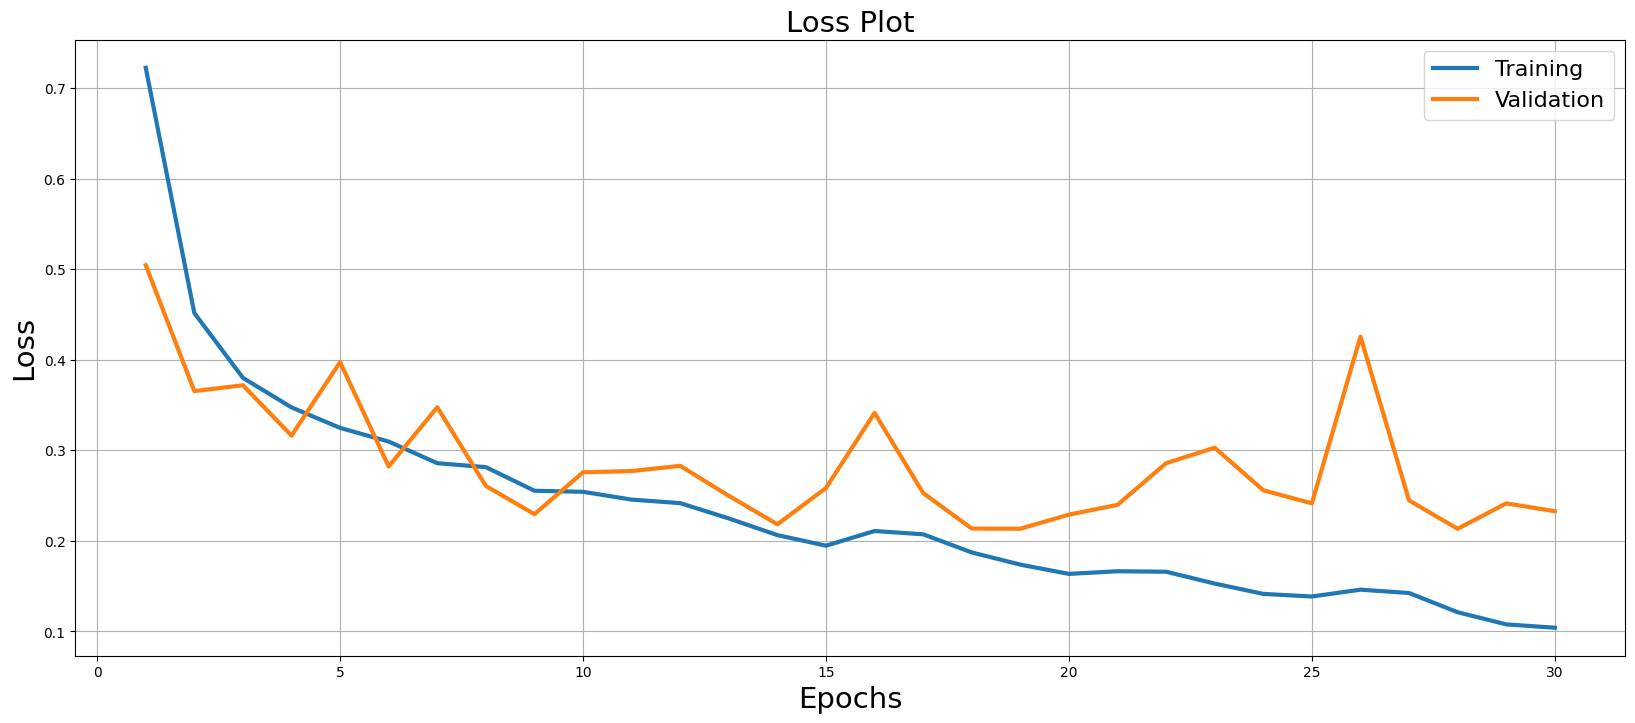

In [21]:
plt.figure(figsize=(20,8))
plt.plot(logs_df.Epoch.tolist(), logs_df.Train_Loss.tolist(), lw=3, label = 'Training')
plt.plot(logs_df.Epoch.tolist(), logs_df.Val_Loss.tolist(), lw=3, label = 'Validation')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Loss', fontsize=21)
plt.title('Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('Loss.png')
plt.show()

In [22]:
5+6

11